# : 💳 IEEE-CIS Fraud Detection



---



## Workflow:
1. Understand the Dataset
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing
4. Model Building
  *   Logistic Regression
  *   Decision Tree Classifier
  *   Random Forest Classifier
  *   XGBoost Classifier
  *   CatBoost Classifier
5. Model Evaluation



## 📦 Step 1: Import Libraries and Load Data

In [ ]:
# Import required libraries
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc  # Garbage collector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_recall_curve
from google.colab import drive
drive.mount('/content/drive/')

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
Mounted at /content/drive/
✅ All libraries imported successfully!


In [ ]:
print("="*70)
print("MEMORY-EFFICIENT DATA LOADING")
print("="*70)

# Configuration
SAMPLE_SIZE = 100000  # Use 100k transactions
RANDOM_STATE = 42
PATH = "/content/drive/My Drive/"

print(f"\n🎯 Target sample size: {SAMPLE_SIZE:,} transactions")
print(f"   (Original dataset has ~590k transactions)")


print("\n Step 1: Loading target column first")
# First, Check the fraud column to get distribution
df_target = pd.read_csv(PATH + "train_transaction.csv", usecols=['isFraud'])

fraud_rate = df_target['isFraud'].mean()
total_rows = len(df_target)

print(f"    Dataset size: {total_rows} transactions")
print(f"    Fraud rate: {fraud_rate*100:.2f}%")

# Calculate sample sizes to maintain ratio
fraud_sample = int(SAMPLE_SIZE * fraud_rate)
legit_sample = SAMPLE_SIZE - fraud_sample

print(f" Stratified sample will have:")
print(f" Geniune: {legit_sample}")
print(f" Fraud: {fraud_sample}")

# Clean up
del df_target
gc.collect()

# Load full dataset
df_full = pd.read_csv(PATH + "train_transaction.csv")
print(f"   Full dataset loaded: {df_full.shape}")
print(f"   Memory usage: {df_full.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Create stratified sample
print("\n Step 3: Creating stratified sample")
df = df_full.groupby('isFraud', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), int(SAMPLE_SIZE * len(x) / len(df_full))),
                       random_state=RANDOM_STATE)
).reset_index(drop=True)

print(f"   Sample created: {df.shape}")
print(f"   Sample fraud rate: {df['isFraud'].mean()*100:.2f}%")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Clean up full dataset
del df_full
gc.collect()

print("\n" + "="*70)
print(" DATA LOADED EFFICIENTLY!")
print("="*70)

MEMORY-EFFICIENT DATA LOADING

🎯 Target sample size: 100,000 transactions
   (Original dataset has ~590k transactions)

 Step 1: Loading target column first
    Dataset size: 590540 transactions
    Fraud rate: 3.50%
 Stratified sample will have:
 Geniune: 96501
 Fraud: 3499
   Full dataset loaded: (590540, 394)
   Memory usage: 2062.07 MB

 Step 3: Creating stratified sample
   Sample created: (99999, 394)
   Sample fraud rate: 3.50%
   Memory usage: 349.16 MB

 DATA LOADED EFFICIENTLY!


## 📊 Step 1: Understanding the Dataset

In [ ]:
print("="*70)
print("DATASET OVERVIEW")
print("="*70)

print(f"   Rows (Transactions): {df.shape[0]}")
print(f"   Columns (Features): {df.shape[1]}")
print(f"\n🎯 Target Variable (isFraud):")
fraud_counts = df['isFraud'].value_counts()
fraud_counts = df['isFraud'].value_counts()

print(f"   Genuine (0): {fraud_counts[0]} ({fraud_counts[0]/len(df)*100:.2f}%)")
print(f"   Fraudulent (1): {fraud_counts[1]} ({fraud_counts[1]/len(df)*100:.2f}%)")
print(f"   Imbalance Ratio: {fraud_counts[0]/fraud_counts[1]:.1f}:1")

print("\n   Data types: ")
print(df.dtypes.value_counts())
print("\n   Sample of first 5 rows:")
display(df.head())


DATASET OVERVIEW
   Rows (Transactions): 99999
   Columns (Features): 394

🎯 Target Variable (isFraud):
   Genuine (0): 96500 (96.50%)
   Fraudulent (1): 3499 (3.50%)
   Imbalance Ratio: 27.6:1

   Data types: 
float64    376
object      14
int64        4
Name: count, dtype: int64

   Sample of first 5 rows:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3206206,0,5151894,25.00,H,8406,264.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3174783,0,4202454,200.00,R,18080,111.0,150.0,mastercard,219.0,...,0.0,200.0,650.0,200.0,0.0,450.0,0.0,0.0,0.0,0.0
2,3022892,0,869878,146.00,W,8406,264.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3018989,0,783090,57.95,W,11218,579.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3053086,0,1479490,49.00,W,12570,462.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 📊 Step 2: Exploratory Data Analysis (EDA)

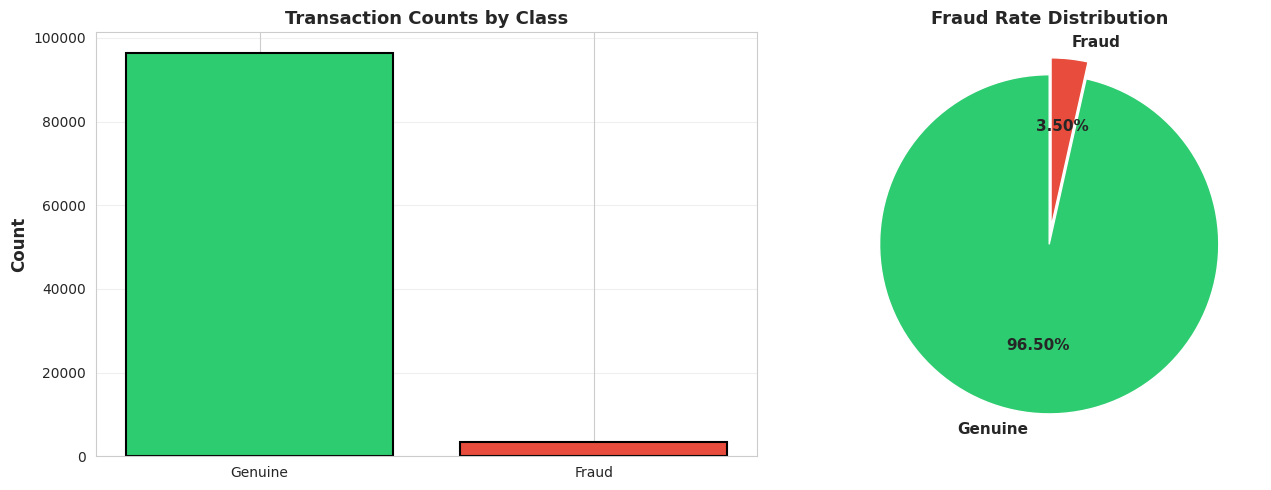


   Highly imbalanced dataset (~3.5% fraud)


In [ ]:
# 2.1 Visualize fraud distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Genuine', 'Fraud'], fraud_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Transaction Counts by Class', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart
axes[1].pie(fraud_counts.values,
           labels=['Genuine', 'Fraud'],
           autopct='%1.2f%%',
           colors=colors,
           startangle=90,
           explode=[0, 0.1],
           textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Fraud Rate Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n   Highly imbalanced dataset (~3.5% fraud)")



TRANSACTION AMOUNT ANALYSIS

 Genuine Transactions:
   Mean: $134.19
   Median: $68.95
   Min: $0.27
   Max: $31937.39

 Fraudulent Transactions:
   Mean: $153.71
   Median: $73.95
   Min: $0.42
   Max: $5191.00


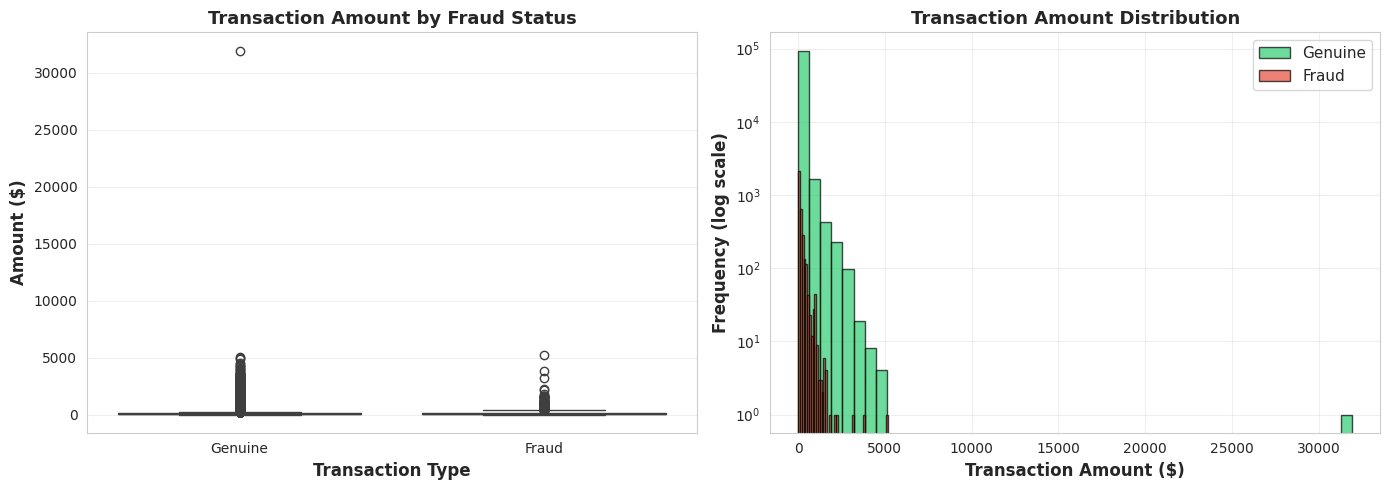

Key Insight: Fraud appears predominantly in smaller transactions


In [ ]:
#2.2 Explore relationship between isFraud and other variables
print("="*70)
print("TRANSACTION AMOUNT ANALYSIS")
print("="*70)

legit_amt = df[df['isFraud'] == 0]['TransactionAmt']
fraud_amt = df[df['isFraud'] == 1]['TransactionAmt']

print("\n Genuine Transactions:")
print(f"   Mean: ${legit_amt.mean():.2f}")
print(f"   Median: ${legit_amt.median():.2f}")
print(f"   Min: ${legit_amt.min():.2f}")
print(f"   Max: ${legit_amt.max():.2f}")

print("\n Fraudulent Transactions:")
print(f"   Mean: ${fraud_amt.mean():.2f}")
print(f"   Median: ${fraud_amt.median():.2f}")
print(f"   Min: ${fraud_amt.min():.2f}")
print(f"   Max: ${fraud_amt.max():.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=df, x='isFraud', y='TransactionAmt', ax=axes[0])
axes[0].set_xlabel('Transaction Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Transaction Amount by Fraud Status', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['Genuine', 'Fraud'])
axes[0].grid(True, alpha=0.3, axis='y')

# Histogram (log scale)
axes[1].hist(legit_amt, bins=50, alpha=0.7, label='Genuine', color='#2ecc71', edgecolor='black')
axes[1].hist(fraud_amt, bins=50, alpha=0.7, label='Fraud', color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Transaction Amount ($)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency (log scale)', fontsize=12, fontweight='bold')
axes[1].set_title('Transaction Amount Distribution', fontsize=13, fontweight='bold')
axes[1].set_yscale('log')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Key Insight: Fraud appears predominantly in smaller transactions")

PRODUCT CODE ANALYSIS

 Fraud Rate by Product:
           Fraud_Count  Total_Count  Fraud_Rate
ProductCD                                      
C                 1323        11659   11.347457
S                  117         1967    5.948144
H                  277         5645    4.906997
R                  229         6356    3.602895
W                 1553        74372    2.088151


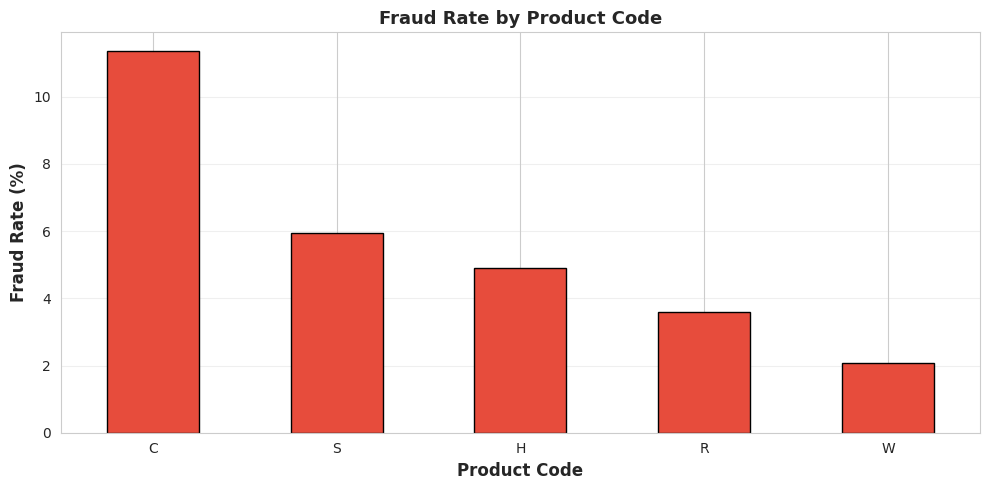

Key Insight: Product C has the highest fraud rate


In [ ]:
print("="*70)
print("PRODUCT CODE ANALYSIS")
print("="*70)

# Fraud rate by product
fraud_by_product = df.groupby('ProductCD')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_product.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
fraud_by_product['Fraud_Rate'] = fraud_by_product['Fraud_Rate'] * 100
fraud_by_product = fraud_by_product.sort_values('Fraud_Rate', ascending=False)
print("\n Fraud Rate by Product:")
print(fraud_by_product)

# Visualization
plt.figure(figsize=(10, 5))
fraud_by_product['Fraud_Rate'].plot(kind='bar', color='#e74c3c', edgecolor='black')
plt.xlabel('Product Code', fontsize=12, fontweight='bold')
plt.ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
plt.title('Fraud Rate by Product Code', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()
print("Key Insight: Product C has the highest fraud rate")

CARD TYPE ANALYSIS

 Fraud Rate by Card Type:
                  Fraud_Count  Total_Count  Fraud_Rate
card4                                                 
discover                  103         1112    9.262590
visa                     2293        65181    3.517896
mastercard               1060        32000    3.312500
american express           35         1433    2.442428


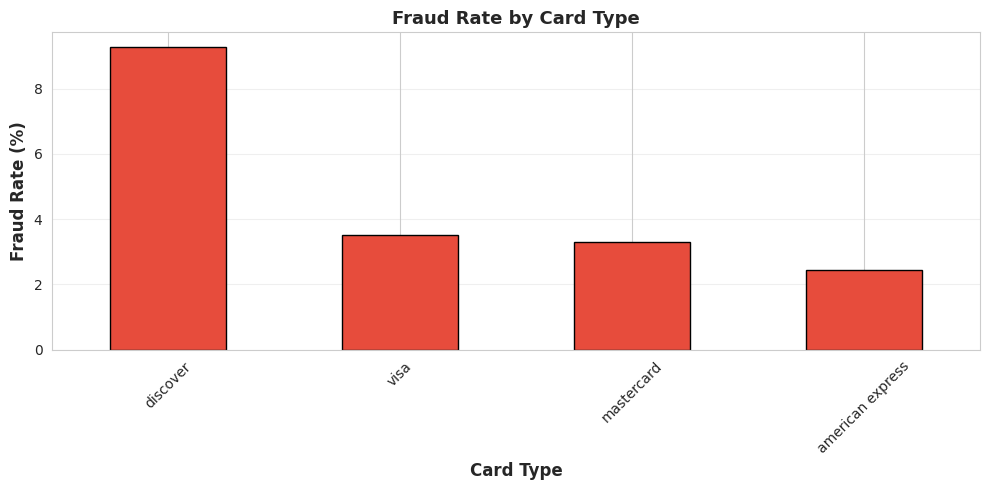

Key Insight: Key Insight: Discover cards represent a significantly higher fraud risk compared to other card types.


In [ ]:
 print("="*70)
 print("CARD TYPE ANALYSIS")
 print("="*70)

 fraud_by_card = df.groupby('card4')['isFraud'].agg(['sum', 'count', 'mean'])
 fraud_by_card.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
 fraud_by_card['Fraud_Rate'] = fraud_by_card['Fraud_Rate'] * 100
 fraud_by_card = fraud_by_card.sort_values('Fraud_Rate', ascending=False)
 print("\n Fraud Rate by Card Type:")
 print(fraud_by_card)

 # Visualization
 plt.figure(figsize=(10, 5))
 fraud_by_card['Fraud_Rate'].plot(kind='bar', color='#e74c3c', edgecolor='black')
 plt.xlabel('Card Type', fontsize=12, fontweight='bold')
 plt.ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold')
 plt.title('Fraud Rate by Card Type', fontsize=13, fontweight='bold')
 plt.grid(True, alpha=0.3, axis='y')
 plt.xticks(rotation=45)
 plt.tight_layout()
 plt.show()
 print("Key Insight: Key Insight: Discover cards represent a significantly higher fraud risk compared to other card types.")


In [ ]:
# 2.3 Missing value and Outliers analysis
print("="*70)
print("MISSING VALUES ANALYSIS")
print("="*70)

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100)

missing_df = pd.DataFrame({
    'Feature': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"\n Summary:")
print(f"   Features with missing values: {len(missing_df)}")
print(f"   Features with >50% missing: {(missing_pct > 50).sum()}")
print(f"   Features with >80% missing: {(missing_pct > 80).sum()}")

print(f"\n Top 20 Features with Most Missing:")
print(missing_df.head(20).to_string(index=False))

MISSING VALUES ANALYSIS

 Summary:
   Features with missing values: 374
   Features with >50% missing: 174
   Features with >80% missing: 55

 Top 20 Features with Most Missing:
Feature  Missing_Count  Missing_Percentage
  dist2          93590           93.590936
     D7          93378           93.378934
    D14          89529           89.529895
    D13          89447           89.447894
    D12          88993           88.993890
     D6          87544           87.544875
     D8          87239           87.239872
     D9          87239           87.239872
   V154          86106           86.106861
   V153          86106           86.106861
   V162          86106           86.106861
   V161          86106           86.106861
   V163          86106           86.106861
   V155          86106           86.106861
   V156          86106           86.106861
   V138          86106           86.106861
   V142          86106           86.106861
   V149          86106           86.106861
   V1

In [ ]:
print("="*70)
print("OUTLIER DETECTION - IQR METHOD")
print("="*70)

print("\n IQR (Interquartile Range) Method:")
print("   1. Calculate Q1 (25th percentile) and Q3 (75th percentile)")
print("   2. IQR = Q3 - Q1")
print("   3. Lower bound = Q1 - 1.5 × IQR")
print("   4. Upper bound = Q3 + 1.5 × IQR")
print("   5. Values outside these bounds = outliers")

# Calculate outliers for TransactionAmt
Q1 = df['TransactionAmt'].quantile(0.25)
Q3 = df['TransactionAmt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\n For TransactionAmt:")
print(f"   Q1 (25th percentile): ${Q1:.2f}")
print(f"   Q3 (75th percentile): ${Q3:.2f}")
print(f"   IQR: ${IQR:.2f}")
print(f"   Lower bound: ${lower_bound:.2f}")
print(f"   Upper bound: ${upper_bound:.2f}")

# Identify outliers
outliers = df[(df['TransactionAmt'] < lower_bound) | (df['TransactionAmt'] > upper_bound)]

print(f"\n Outlier Statistics:")
print(f"   Total outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}% of data)")
print(f"   Outliers that are fraud: {outliers['isFraud'].sum():,}")
print(f"   Fraud rate in outliers: {outliers['isFraud'].mean()*100:.2f}%")
print(f"   Overall fraud rate: {df['isFraud'].mean()*100:.2f}%")

# calculate fraud rate ratio to total fraud
fraud_rate_ratio = outliers['isFraud'].mean() / df['isFraud'].mean()
print(f"\n Key Finding:")
if fraud_rate_ratio > 1.5:
    print(f"    Outliers have {fraud_rate_ratio:.1f}x HIGHER fraud rate!")
    print(f"   This suggests unusual transaction amounts are suspicious!")
elif fraud_rate_ratio < 0.7:
    print(f"   Outliers have LOWER fraud rate ({fraud_rate_ratio:.1f}x)")
    print(f"   Large transactions might actually be more legitimate.")
else:
    print(f"   Outliers have similar fraud rate ({fraud_rate_ratio:.1f}x)")
    print(f"   Transaction amount alone may not be a strong outlier indicator.")




OUTLIER DETECTION - IQR METHOD

 IQR (Interquartile Range) Method:
   1. Calculate Q1 (25th percentile) and Q3 (75th percentile)
   2. IQR = Q3 - Q1
   3. Lower bound = Q1 - 1.5 × IQR
   4. Upper bound = Q3 + 1.5 × IQR
   5. Values outside these bounds = outliers

 For TransactionAmt:
   Q1 (25th percentile): $43.38
   Q3 (75th percentile): $125.00
   IQR: $81.62
   Lower bound: $-79.05
   Upper bound: $247.43

 Outlier Statistics:
   Total outliers: 11,231 (11.23% of data)
   Outliers that are fraud: 597
   Fraud rate in outliers: 5.32%
   Overall fraud rate: 3.50%

 Key Finding:
    Outliers have 1.5x HIGHER fraud rate!
   This suggests unusual transaction amounts are suspicious!


In [ ]:
print("="*70)
print("SEPARATING FEATURES INTO NUMERICAL AND CATEGORICAL")
print("="*70)

# Numerical features (numbers)
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID and target columns
numerical_features = [col for col in numerical_features
                     if col not in ['TransactionID', 'isFraud', 'TransactionDT']]

# Categorical features (text/objects)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n Feature Summary:")
print(f"   Numerical features: {len(numerical_features)}")
print(f"   Categorical features: {len(categorical_features)}")
print(f"   Total: {len(numerical_features) + len(categorical_features)}")

print(f"\n Numerical features examples:")
print(f"   {numerical_features[:10]}")

print(f"\n Categorical features:")
print(f"   {categorical_features}")

SEPARATING FEATURES INTO NUMERICAL AND CATEGORICAL

 Feature Summary:
   Numerical features: 377
   Categorical features: 14
   Total: 391

 Numerical features examples:
   ['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1']

 Categorical features:
   ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


# 📊 Step 3: Data Preprocessing

In [ ]:
print("="*70)
print("STEP 3.1: HANDLE MISSING VALUES")
print("="*70)
# Separate X and y
X = df.drop(['isFraud', 'TransactionID'], axis=1, errors='ignore')
y = df['isFraud']

print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Check missing values before
missing_before = X.isnull().sum().sum()
print(f"\n Missing values BEFORE: {missing_before:,}")

# Identify features with >80% missing
missing_pct = (X.isnull().sum() / len(X)) * 100
cols_to_drop = missing_pct[missing_pct > 80].index.tolist()
# print(cols_to_drop)
print(f"  Dropping {len(cols_to_drop)} columns with >80% missing:")
if len(cols_to_drop) > 0:
    print(f"   {cols_to_drop[:10]}..." if len(cols_to_drop) > 10 else f"   {cols_to_drop}")
    X = X.drop(columns=cols_to_drop)

 # Update feature lists
numerical_features = [f for f in numerical_features if f not in cols_to_drop]
categorical_features = [f for f in categorical_features if f not in cols_to_drop]

# Impute NUMERICAL features with median
print("\n Imputing NUMERICAL features with MEDIAN...")

num_features_in_X = [f for f in numerical_features if f in X.columns]

if len(num_features_in_X) > 0:
    # Check missing before
    num_missing_before = X[num_features_in_X].isnull().sum().sum()
    print(f"   Missing values in numerical features: {num_missing_before:,}")

    # Impute with median
    numerical_imputer = SimpleImputer(strategy='median')
    X[num_features_in_X] = numerical_imputer.fit_transform(X[num_features_in_X])
# Check after
num_missing_after = X[num_features_in_X].isnull().sum().sum()
print(f"   Missing values after imputation: {num_missing_after:,}")

# Impute CATEGORICAL features with MOST FREQUENT
print("\n Imputing CATEGORICAL features with MOST FREQUENT")

cat_features_in_X = [f for f in categorical_features if f in X.columns]

if len(cat_features_in_X) > 0:
    # Check missing before
    cat_missing_before = X[cat_features_in_X].isnull().sum().sum()
    print(f"   Missing values in categorical features: {cat_missing_before:,}")

    # Impute with most frequent (mode)
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X[cat_features_in_X] = categorical_imputer.fit_transform(X[cat_features_in_X])

    # Check after
    cat_missing_after = X[cat_features_in_X].isnull().sum().sum()
    print(f"   Missing values after imputation: {cat_missing_after:,}")

# missing value after
missing_After = X.isnull().sum().sum()
print(f"\n Missing values After: {missing_After}")

print("\n STEP 3.1: Missing Values")
print(f"   • Dropped features with >80% missing")
print(f"   • Imputed numerical with median")
print(f"   • Imputed categorical with mode")
print(f"   • Result: 0 missing values")


STEP 3.1: HANDLE MISSING VALUES
  X shape: (99999, 392)
  y shape: (99999,)

 Missing values BEFORE: 16,185,722
  Dropping 55 columns with >80% missing:
   ['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139']...

 Imputing NUMERICAL features with MEDIAN...
   Missing values in numerical features: 10,879,287
   Missing values after imputation: 0

 Imputing CATEGORICAL features with MOST FREQUENT
   Missing values in categorical features: 543,855
   Missing values after imputation: 0

 Missing values After: 0

 STEP 3.1: Missing Values
   • Dropped features with >80% missing
   • Imputed numerical with median
   • Imputed categorical with mode
   • Result: 0 missing values


In [ ]:
print("="*70)
print("STEP 3.2: ENCODE CATEGORICAL FEATURES")
print("="*70)

print(f"\n Encoding {len(cat_features_in_X)} categorical features")

if len(cat_features_in_X) > 0:
    for col in cat_features_in_X:
        # Check unique values
        n_unique = X[col].nunique()
        print(f"\n   {col}:")
        print(f"      Unique values: {n_unique}")

        # Label encode
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        print(f"    Encoded to: 0-{n_unique-1}")

print("\n STEP 3.2: Categorical Encoding")
print(f"   • Encoded {len(cat_features_in_X)} categorical features")
print(f"   • Method: Label Encoding")
print(f"   • Result: All features are numeric")

STEP 3.2: ENCODE CATEGORICAL FEATURES

 Encoding 14 categorical features

   ProductCD:
      Unique values: 5
    Encoded to: 0-4

   card4:
      Unique values: 4
    Encoded to: 0-3

   card6:
      Unique values: 4
    Encoded to: 0-3

   P_emaildomain:
      Unique values: 59
    Encoded to: 0-58

   R_emaildomain:
      Unique values: 58
    Encoded to: 0-57

   M1:
      Unique values: 2
    Encoded to: 0-1

   M2:
      Unique values: 2
    Encoded to: 0-1

   M3:
      Unique values: 2
    Encoded to: 0-1

   M4:
      Unique values: 3
    Encoded to: 0-2

   M5:
      Unique values: 2
    Encoded to: 0-1

   M6:
      Unique values: 2
    Encoded to: 0-1

   M7:
      Unique values: 2
    Encoded to: 0-1

   M8:
      Unique values: 2
    Encoded to: 0-1

   M9:
      Unique values: 2
    Encoded to: 0-1

 STEP 3.2: Categorical Encoding
   • Encoded 14 categorical features
   • Method: Label Encoding
   • Result: All features are numeric


In [ ]:
print("="*70)
print("STEP 3.3: TRAIN-TEST SPLIT (STRATIFIED)")
print("="*70)

print(f"\n Original Dataset:")
print(f"   Total samples: {len(X):,}")
print(f"   Fraud rate: {y.mean()*100:.2f}%")
print(f"   Frauds: {y.sum():,}")
print(f"   Genuine: {(y==0).sum():,}")

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintains fraud ratio!
)

print(f"\n Training Set (80%):")
print(f"   Samples: {len(X_train):,}")
print(f"   Fraud rate: {y_train.mean()*100:.2f}%")
print(f"   Frauds: {y_train.sum():,}")
print(f"   Genuine: {(y_train==0).sum():,}")

print(f"\n Test Set (20%):")
print(f"   Samples: {len(X_test):,}")
print(f"   Fraud rate: {y_test.mean()*100:.2f}%")
print(f"   Frauds: {y_test.sum():,}")
print(f"   Genuine: {(y_test==0).sum():,}")

# Initialize scaler
scaler = StandardScaler()
# Fit on training data ONLY
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame  for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


print(f" After Scaling (Training Set):")
print(f"   TransactionAmt mean {X_train_scaled['TransactionAmt'].mean():.6f} (≈0)")
print(f"   TransactionAmt std  {X_train_scaled['TransactionAmt'].std():.6f} (≈1)")

print("DATA READY FOR MODELING")


STEP 3.3: TRAIN-TEST SPLIT (STRATIFIED)

 Original Dataset:
   Total samples: 99,999
   Fraud rate: 3.50%
   Frauds: 3,499
   Genuine: 96,500

 Training Set (80%):
   Samples: 79,999
   Fraud rate: 3.50%
   Frauds: 2,799
   Genuine: 77,200

 Test Set (20%):
   Samples: 20,000
   Fraud rate: 3.50%
   Frauds: 700
   Genuine: 19,300
 After Scaling (Training Set):
   TransactionAmt mean -0.000000 (≈0)
   TransactionAmt std  1.000006 (≈1)
DATA READY FOR MODELING


# 📊 Step 4: Model building

In [ ]:
print("="*70)
print("MODEL 4.1: LOGISTIC REGRESSION (BASELINE)")
print("="*70)

print(" Training Logistic Regression")
start_time = time.time()

# Initialize with class weights to handle imbalance
# Since we have imbalance class we use class_weight= 'balanced'
# as a result Minority class → higher weight, Majority class → lower weight
# Model is punished more for misclassifying rare cases


lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# Train
lr_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

lr_time = time.time() - start_time

print(f" Training complete in {lr_time:.2f} seconds")

# Calculate metrics
lr_accuracy = accuracy_score(y_test, lr_pred) #Checks overall  correcteness
lr_precision = precision_score(y_test, lr_pred) # of predicted positives how many were correct
lr_recall = recall_score(y_test, lr_pred) # of actual positives how many did we catch
lr_f1 = f1_score(y_test, lr_pred) # Balance between precision and recall
lr_roc_auc = roc_auc_score(y_test, lr_pred_proba) # How well the model separates classes

print(f" Performance Metrics:")
print(f"   Accuracy:  {lr_accuracy:.4f}")
print(f"   Precision: {lr_precision:.4f}")
print(f"   Recall:    {lr_recall:.4f}")
print(f"   F1-Score:  {lr_f1:.4f}")
print(f"   ROC-AUC:   {lr_roc_auc:.4f}")

MODEL 4.1: LOGISTIC REGRESSION (BASELINE)
 Training Logistic Regression
 Training complete in 49.93 seconds
 Performance Metrics:
   Accuracy:  0.6199
   Precision: 0.0629
   Recall:    0.7100
   F1-Score:  0.1156
   ROC-AUC:   0.7340


In [ ]:
print("="*70)
print("MODEL 4.2: DECISION TREE CLASSIFIER")
print("="*70)

print(" Training Decision Tree")
start_time = time.time()

# Initialize
dt_model = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

# Train
dt_model.fit(X_train, y_train)

# Predictions
dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]

dt_time = time.time() - start_time

print(f" Training complete in {dt_time:.2f} seconds")

# Calculate metrics
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_roc_auc = roc_auc_score(y_test, dt_pred_proba)

print(f" Performance Metrics:")
print(f"   Accuracy:  {dt_accuracy:.4f}")
print(f"   Precision: {dt_precision:.4f}")
print(f"   Recall:    {dt_recall:.4f}")
print(f"   F1-Score:  {dt_f1:.4f}")
print(f"   ROC-AUC:   {dt_roc_auc:.4f}")

MODEL 4.2: DECISION TREE CLASSIFIER
 Training Decision Tree
 Training complete in 3.65 seconds
 Performance Metrics:
   Accuracy:  0.8370
   Precision: 0.1380
   Recall:    0.6971
   F1-Score:  0.2304
   ROC-AUC:   0.8052


In [ ]:
print("="*70)
print("MODEL 4.3: RANDOM FOREST CLASSIFIER")
print("="*70)

print(" Training Random Forest")
start_time = time.time()

# Initialize
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

rf_time = time.time() - start_time

print(f" Training complete in {rf_time:.2f} seconds ({rf_time/60:.2f} minutes)")

# Calculate metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)

print(f" Performance Metrics:")
print(f"   Accuracy:  {rf_accuracy:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall:    {rf_recall:.4f}")
print(f"   F1-Score:  {rf_f1:.4f}")
print(f"   ROC-AUC:   {rf_roc_auc:.4f}")

MODEL 4.3: RANDOM FOREST CLASSIFIER
 Training Random Forest
 Training complete in 19.23 seconds (0.32 minutes)
 Performance Metrics:
   Accuracy:  0.9408
   Precision: 0.3161
   Recall:    0.5943
   F1-Score:  0.4127
   ROC-AUC:   0.8859


In [ ]:
print("="*70)
print("MODEL 4.4: XGBOOST CLASSIFIER")
print("="*70)

print("\n Training XGBoost")
start_time = time.time()

# Calculate scale_pos_weight for XGBoost
# This is XGBoost way of imbalance treatment
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"   scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

# Train
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

xgb_time = time.time() - start_time

print(f" Training complete in {xgb_time:.2f} seconds")

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f" Performance Metrics:")
print(f"   Accuracy:  {xgb_accuracy:.4f}")
print(f"   Precision: {xgb_precision:.4f}")
print(f"   Recall:    {xgb_recall:.4f}")
print(f"   F1-Score:  {xgb_f1:.4f}")
print(f"   ROC-AUC:   {xgb_roc_auc:.4f}")

MODEL 4.4: XGBOOST CLASSIFIER

 Training XGBoost
   scale_pos_weight: 27.58
 Training complete in 13.46 seconds
 Performance Metrics:
   Accuracy:  0.9206
   Precision: 0.2657
   Recall:    0.7186
   F1-Score:  0.3880
   ROC-AUC:   0.9030


In [ ]:
print("="*70)
print("MODEL 4.5: CATBOOST CLASSIFIER")
print("="*70)

print(" Training CatBoost")
start_time = time.time()

# Initialize
cb_model = CatBoostClassifier(
    iterations=100,
    depth=7,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=False
)

# Train
cb_model.fit(X_train, y_train)

# Predictions
cb_pred = cb_model.predict(X_test)
cb_pred_proba = cb_model.predict_proba(X_test)[:, 1]

cb_time = time.time() - start_time

print(f" Training complete in {cb_time:.2f} seconds")

# Calculate metrics
cb_accuracy = accuracy_score(y_test, cb_pred)
cb_precision = precision_score(y_test, cb_pred)
cb_recall = recall_score(y_test, cb_pred)
cb_f1 = f1_score(y_test, cb_pred)
cb_roc_auc = roc_auc_score(y_test, cb_pred_proba)

print(f" Performance Metrics:")
print(f"   Accuracy:  {cb_accuracy:.4f}")
print(f"   Precision: {cb_precision:.4f}")
print(f"   Recall:    {cb_recall:.4f}")
print(f"   F1-Score:  {cb_f1:.4f}")
print(f"   ROC-AUC:   {cb_roc_auc:.4f}")

MODEL 4.5: CATBOOST CLASSIFIER
 Training CatBoost
 Training complete in 17.65 seconds
 Performance Metrics:
   Accuracy:  0.8630
   Precision: 0.1678
   Recall:    0.7357
   F1-Score:  0.2732
   ROC-AUC:   0.8882


In [ ]:
print("="*70)
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'CatBoost'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy, xgb_accuracy, cb_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision, xgb_precision, cb_precision],
    'Recall': [lr_recall, dt_recall, rf_recall, xgb_recall, cb_recall],
    'F1-Score': [lr_f1, dt_f1, rf_f1, xgb_f1, cb_f1],
    'ROC-AUC': [lr_roc_auc, dt_roc_auc, rf_roc_auc, xgb_roc_auc, cb_roc_auc],
    'Training Time (s)': [lr_time, dt_time, rf_time, xgb_time, cb_time]
})

print(" All Models Performance:")
print(results.to_string(index=False))

# Find best model by ROC-AUC
best_idx = results['ROC-AUC'].idxmax()
best_model = results.loc[best_idx, 'Model']
best_roc = results.loc[best_idx, 'ROC-AUC']

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   ROC-AUC: {best_roc:.4f}")

MODEL COMPARISON
 All Models Performance:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
Logistic Regression   0.61985   0.062935 0.710000  0.115622 0.733951          71.123640
      Decision Tree   0.83700   0.138009 0.697143  0.230406 0.805164           3.650559
      Random Forest   0.94080   0.316109 0.594286  0.412698 0.885874          19.233527
            XGBoost   0.92065   0.265716 0.718571  0.387968 0.902968          13.458518
           CatBoost   0.86300   0.167752 0.735714  0.273210 0.888240          17.654003

🏆 BEST MODEL: XGBoost
   ROC-AUC: 0.9030


In [ ]:
print("="*70)
print("DUMMY TRANSACTION PREDICTION")
print("="*70)

print(" Creating dummy transaction")

# Create a dummy transaction based on test set statistics
dummy_transaction = pd.DataFrame({
    col: [X_test[col].median()] for col in X_test.columns
})

# Modify some values to make it suspicious
if 'TransactionAmt' in dummy_transaction.columns:
    dummy_transaction['TransactionAmt'] = 500.0  # High amount

print(f" Dummy Transaction Details:")
print(f"   TransactionAmt: ${dummy_transaction['TransactionAmt'].values[0]:.2f}")
print(f"   Shape: {dummy_transaction.shape}")
print(f"   All features: {len(dummy_transaction.columns)}")

print(" Predictions from all models:\n")

models = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'CatBoost': cb_model
}

for name, model in models.items():
    pred = model.predict(dummy_transaction)[0]
    proba = model.predict_proba(dummy_transaction)[0, 1]

    result = "FRAUD" if pred == 1 else "GENUINE"

    print(f"   {name:25s} → {result:15s} (Fraud probability: {proba*100:.2f}%)")

print("\n💡 Interpretation:")
fraud_votes = sum([model.predict(dummy_transaction)[0] for model in models.values()])
print(f"   {fraud_votes}/5 models predict FRAUD")

if fraud_votes >= 3:
    print(f"   → Majority vote: This transaction is SUSPICIOUS!")
else:
    print(f"   → Majority vote: This transaction appears GENUINE")

DUMMY TRANSACTION PREDICTION
 Creating dummy transaction
 Dummy Transaction Details:
   TransactionAmt: $500.00
   Shape: (1, 337)
   All features: 337
 Predictions from all models:

   Logistic Regression       → FRAUD           (Fraud probability: 50.85%)
   Decision Tree             → FRAUD           (Fraud probability: 59.88%)
   Random Forest             → GENUINE         (Fraud probability: 35.16%)
   XGBoost                   → GENUINE         (Fraud probability: 47.88%)
   CatBoost                  → GENUINE         (Fraud probability: 40.83%)

💡 Interpretation:
   2/5 models predict FRAUD
   → Majority vote: This transaction appears GENUINE


In [ ]:
print("="*70)
print("GRIDSEARCHCV: HYPERPARAMETER TUNING")
print("="*70)

print(" Model: Random Forest Classifier")
print("   We'll tune this model using GridSearchCV")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}

print(f" Parameter Grid:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n   Total combinations: {total_combinations}")
print(f"   With 3-fold CV: {total_combinations * 3} fits")

print("\n Running GridSearchCV")
start_time = time.time()

# Initialize base model
rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# GridSearch with stratified CV
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Use ROC-AUC for imbalanced data
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

grid_time = time.time() - start_time

print(f" GridSearch complete in {grid_time:.2f} seconds ({grid_time/60:.2f} minutes)")

GRIDSEARCHCV: HYPERPARAMETER TUNING
 Model: Random Forest Classifier
   We'll tune this model using GridSearchCV
 Parameter Grid:
   n_estimators: [50, 100, 200]
   max_depth: [10, 15, 20]
   min_samples_split: [10, 20, 30]
   min_samples_leaf: [5, 10, 15]

   Total combinations: 81
   With 3-fold CV: 243 fits

⏳ Running GridSearchCV
Fitting 3 folds for each of 81 candidates, totalling 243 fits
 GridSearch complete in 3758.46 seconds (62.64 minutes)


In [ ]:
# Display best parameters
print(" BEST PARAMETERS FOUND:")
print("="*70)

for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f" Best Cross-Validation ROC-AUC: {grid_search.best_score_:.4f}")

# Get best model
rf_tuned = grid_search.best_estimator_

# Test on test set
print(" Testing tuned model on test set")
rf_tuned_pred = rf_tuned.predict(X_test)
rf_tuned_proba = rf_tuned.predict_proba(X_test)[:, 1]

# Metrics
rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_pred)
rf_tuned_precision = precision_score(y_test, rf_tuned_pred)
rf_tuned_recall = recall_score(y_test, rf_tuned_pred)
rf_tuned_f1 = f1_score(y_test, rf_tuned_pred)
rf_tuned_roc_auc = roc_auc_score(y_test, rf_tuned_proba)

print(f" TUNED MODEL Performance:")
print(f"   Accuracy:  {rf_tuned_accuracy:.4f}")
print(f"   Precision: {rf_tuned_precision:.4f}")
print(f"   Recall:    {rf_tuned_recall:.4f}")
print(f"   F1-Score:  {rf_tuned_f1:.4f}")
print(f"   ROC-AUC:   {rf_tuned_roc_auc:.4f}")

print(f" IMPROVEMENT from default Random Forest:")
print(f"   Accuracy:  {rf_tuned_accuracy - rf_accuracy:+.4f}")
print(f"   Precision: {rf_tuned_precision - rf_precision:+.4f}")
print(f"   Recall:    {rf_tuned_recall - rf_recall:+.4f}")
print(f"   F1-Score:  {rf_tuned_f1 - rf_f1:+.4f}")
print(f"   ROC-AUC:   {rf_tuned_roc_auc - rf_roc_auc:+.4f}")

if rf_tuned_roc_auc > rf_roc_auc:
    print(f" Tuning IMPROVED performance!")
else:
    print(f"  Tuning didn't improve much (default was already good)")



 BEST PARAMETERS FOUND:
   max_depth: 20
   min_samples_leaf: 10
   min_samples_split: 30
   n_estimators: 200
 Best Cross-Validation ROC-AUC: 0.8914
 Testing tuned model on test set
 TUNED MODEL Performance:
   Accuracy:  0.9500
   Precision: 0.3622
   Recall:    0.5614
   F1-Score:  0.4403
   ROC-AUC:   0.8905
 IMPROVEMENT from default Random Forest:
   Accuracy:  +0.0092
   Precision: +0.0461
   Recall:    -0.0329
   F1-Score:  +0.0276
   ROC-AUC:   +0.0046
 Tuning IMPROVED performance!


In [ ]:
# Add tuned model to comparison
results_final = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest',
              'Random Forest (Tuned)', 'XGBoost', 'CatBoost'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy, rf_tuned_accuracy, xgb_accuracy, cb_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision, rf_tuned_precision, xgb_precision, cb_precision],
    'Recall': [lr_recall, dt_recall, rf_recall, rf_tuned_recall, xgb_recall, cb_recall],
    'F1-Score': [lr_f1, dt_f1, rf_f1, rf_tuned_f1, xgb_f1, cb_f1],
    'ROC-AUC': [lr_roc_auc, dt_roc_auc, rf_roc_auc, rf_tuned_roc_auc, xgb_roc_auc, cb_roc_auc]
})

print("="*70)
print("FINAL MODEL COMPARISON (INCLUDING TUNED)")
print("="*70)
print("\n")
print(results_final.to_string(index=False))

# Best model
best_idx = results_final['ROC-AUC'].idxmax()
best_model_name = results_final.loc[best_idx, 'Model']
best_roc = results_final.loc[best_idx, 'ROC-AUC']

print(f"\n🏆 BEST OVERALL MODEL: {best_model_name}")
print(f"   ROC-AUC: {best_roc:.4f}")

FINAL MODEL COMPARISON (INCLUDING TUNED)


                Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  Logistic Regression   0.61985   0.062935 0.710000  0.115622 0.733951
        Decision Tree   0.83700   0.138009 0.697143  0.230406 0.805164
        Random Forest   0.94080   0.316109 0.594286  0.412698 0.885874
Random Forest (Tuned)   0.95005   0.362212 0.561429  0.440336 0.890453
              XGBoost   0.92065   0.265716 0.718571  0.387968 0.902968
             CatBoost   0.86300   0.167752 0.735714  0.273210 0.888240

🏆 BEST OVERALL MODEL: XGBoost
   ROC-AUC: 0.9030


In [ ]:
# Save best model and results
print("💾 Saving best model and results")

# Determine best model object
if best_model_name == 'Logistic Regression':
    best_model_obj = lr_model
elif best_model_name == 'Decision Tree':
    best_model_obj = dt_model
elif best_model_name == 'Random Forest':
    best_model_obj = rf_model
elif best_model_name == 'Random Forest (Tuned)':
    best_model_obj = rf_tuned
elif best_model_name == 'XGBoost':
    best_model_obj = xgb_model
else:
    best_model_obj = cb_model

# Save
import pickle
with open('best_fraud_model.pkl', 'wb') as f:
    pickle.dump(best_model_obj, f)

# Save results
results_final.to_csv('model_comparison_results.csv', index=False)

print(f" Best model saved: best_fraud_model.pkl")
print(f" Results saved: model_comparison_results.csv")
print(f"\n🎯 Best model: {best_model_name}")

💾 Saving best model and results
 Best model saved: best_fraud_model.pkl
 Results saved: model_comparison_results.csv

🎯 Best model: XGBoost


# 📊 Step 5: Model Evaluation

In [ ]:
print("="*70)
print("STEP 5.1: DETAILED MODEL EVALUATION")
print("="*70)

print(" Calculating additional metrics\n")

# Store detailed metrics
detailed_metrics = []

# Get predictions for all models (from Step 4)
model_predictions = {
    'Logistic Regression': (lr_pred, lr_pred_proba),
    'Decision Tree': (dt_pred, dt_pred_proba),
    'Random Forest': (rf_pred, rf_pred_proba),
    'XGBoost': (xgb_pred, xgb_pred_proba),
    'CatBoost': (cb_pred, cb_pred_proba)
}

for name, (y_pred, y_pred_proba) in model_predictions.items():
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Additional metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

    print(f"{name}:")
    print(f"   TPR (Sensitivity): {tpr:.4f} - Catches {tpr*100:.1f}% of frauds") #How many frauds did we catch?(Recall)
    print(f"   TNR (Specificity): {tnr:.4f} - Correctly IDs {tnr*100:.1f}% of Genuine")#How safe is the model for legit customers?
    print(f"   FPR: {fpr:.4f} - False alarm rate")#How many legit transactions did we incorrectly flag?
    print(f"   FNR: {fnr:.4f} - Missed fraud rate")#How many frauds did we miss?
    print(f"   Confusion: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
    print()

    detailed_metrics.append({
        'Model': name,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    })

detailed_df = pd.DataFrame(detailed_metrics)

STEP 5.1: DETAILED MODEL EVALUATION
 Calculating additional metrics

Logistic Regression:
   TPR (Sensitivity): 0.7100 - Catches 71.0% of frauds
   TNR (Specificity): 0.6166 - Correctly IDs 61.7% of legit
   FPR: 0.3834 - False alarm rate
   FNR: 0.2900 - Missed fraud rate
   Confusion: TP=497, TN=11900, FP=7400, FN=203

Decision Tree:
   TPR (Sensitivity): 0.6971 - Catches 69.7% of frauds
   TNR (Specificity): 0.8421 - Correctly IDs 84.2% of legit
   FPR: 0.1579 - False alarm rate
   FNR: 0.3029 - Missed fraud rate
   Confusion: TP=488, TN=16252, FP=3048, FN=212

Random Forest:
   TPR (Sensitivity): 0.5943 - Catches 59.4% of frauds
   TNR (Specificity): 0.9534 - Correctly IDs 95.3% of legit
   FPR: 0.0466 - False alarm rate
   FNR: 0.4057 - Missed fraud rate
   Confusion: TP=416, TN=18400, FP=900, FN=284

XGBoost:
   TPR (Sensitivity): 0.7186 - Catches 71.9% of frauds
   TNR (Specificity): 0.9280 - Correctly IDs 92.8% of legit
   FPR: 0.0720 - False alarm rate
   FNR: 0.2814 - Missed 

CONFUSION MATRICES


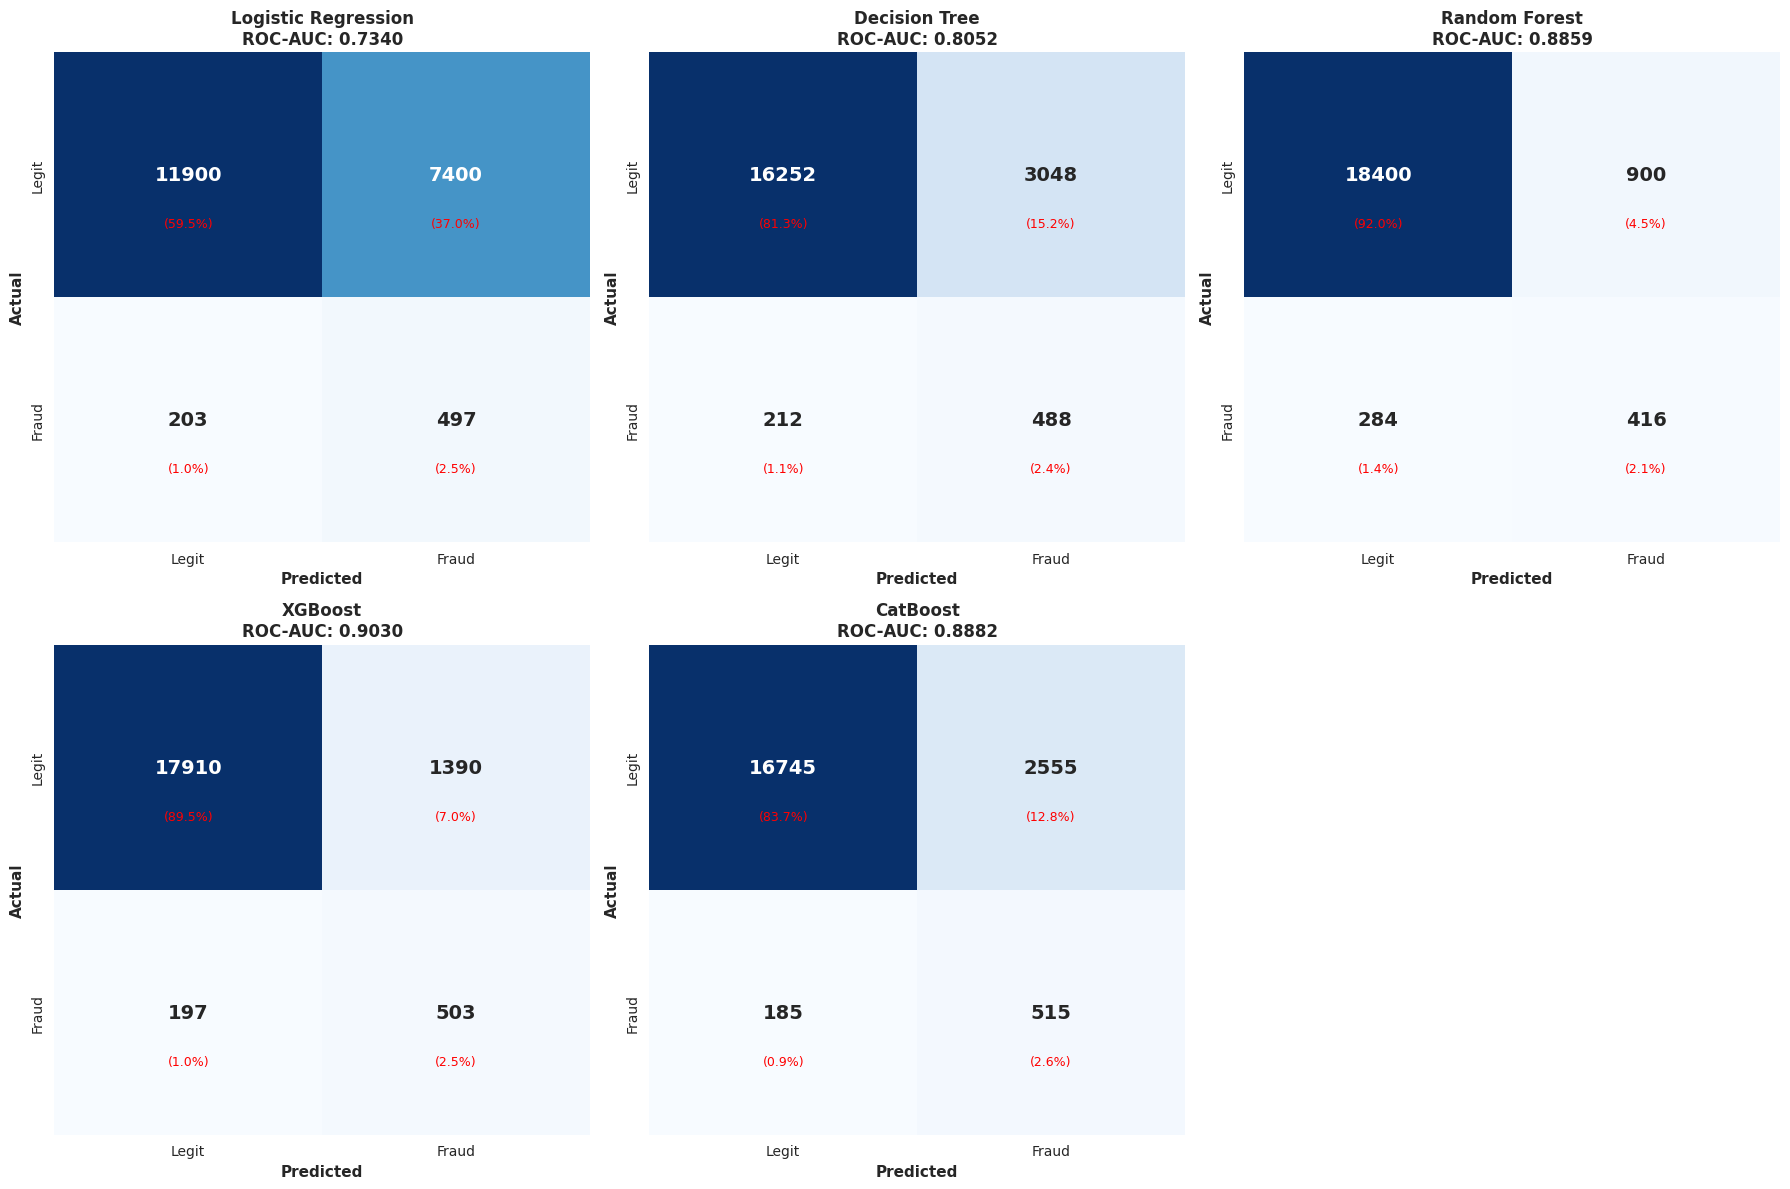


 CONFUSION MATRIX KEY:
   TN (Top-left): Correctly identified legitimate 
   FP (Top-right): FALSE ALARMS - Legit flagged as fraud 
   FN (Bottom-left): MISSED FRAUDS - Fraud marked as legit
   TP (Bottom-right): Correctly caught frauds


In [ ]:
print("="*70)
print("CONFUSION MATRICES")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, row in detailed_df.iterrows():
    cm = np.array([[row['TN'], row['FP']],
                   [row['FN'], row['TP']]])

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Genuine', 'Fraud'],
                yticklabels=['Genuine', 'Fraud'],
                ax=axes[idx], cbar=False,
                annot_kws={'size': 14, 'weight': 'bold'})

    axes[idx].set_xlabel('Predicted', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11, fontweight='bold')

    # Get ROC-AUC from results_final
    roc_auc = results_final[results_final['Model'] == row['Model']]['ROC-AUC'].values[0]
    axes[idx].set_title(f"{row['Model']}\nROC-AUC: {roc_auc:.4f}",
                       fontsize=12, fontweight='bold')

    # Add percentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = (cm[i, j] / total) * 100
            axes[idx].text(j+0.5, i+0.7, f'({pct:.1f}%)',
                         ha='center', va='center', fontsize=9, color='red')

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("\n CONFUSION MATRIX KEY:")
print("   TN (Top-left): Correctly identified legitimate ")
print("   FP (Top-right): FALSE ALARMS - Genuine flagged as fraud ")
print("   FN (Bottom-left): MISSED FRAUDS - Fraud marked as Genuine")
print("   TP (Bottom-right): Correctly caught frauds")

ROC CURVES


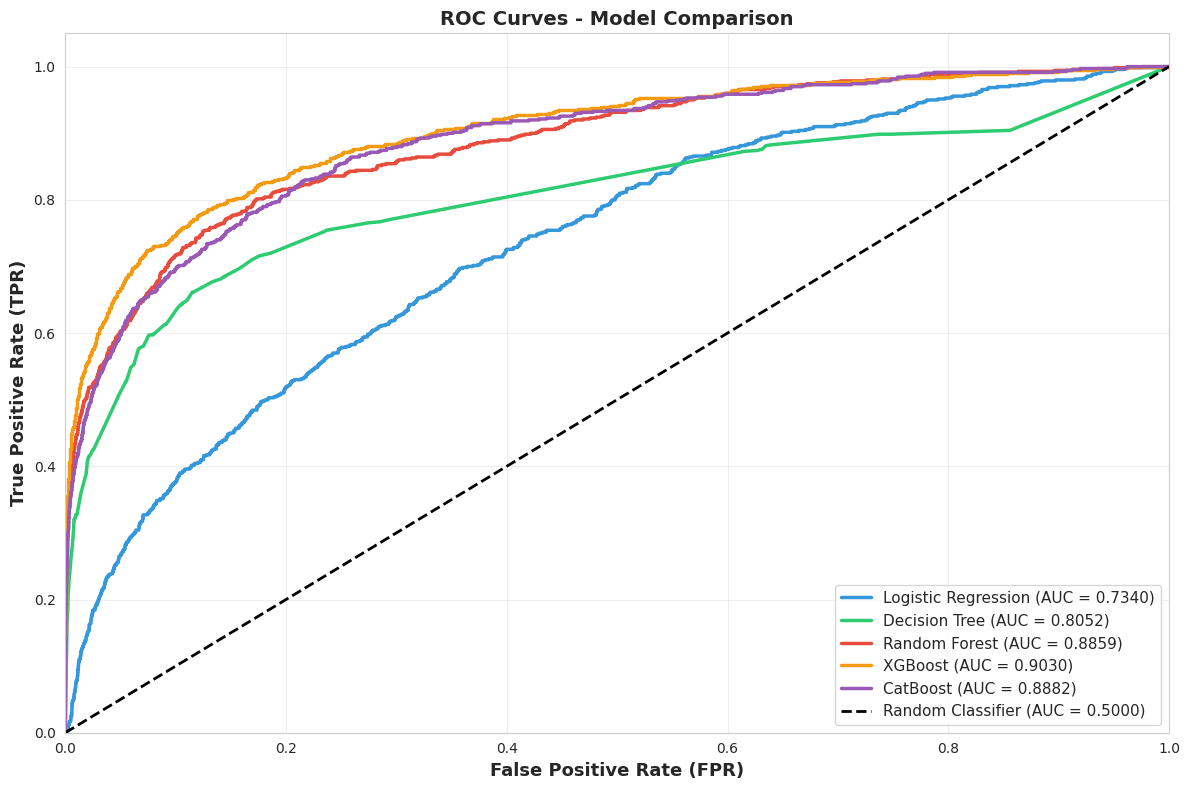


 ROC CURVE INTERPRETATION:
   • Closer to top-left = Better model
   • AUC = 1.0: Perfect classifier
   • AUC = 0.5: Random guessing (diagonal)
   • AUC > 0.8: Good model 


In [ ]:
print("="*70)
print("ROC CURVES")
print("="*70)

plt.figure(figsize=(12, 8))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

for idx, row in detailed_df.iterrows():
    fpr_curve, tpr_curve, _ = roc_curve(y_test, row['y_pred_proba'])
    roc_auc = results_final[results_final['Model'] == row['Model']]['ROC-AUC'].values[0]

    plt.plot(fpr_curve, tpr_curve, color=colors[idx], linewidth=2.5,
            label=f"{row['Model']} (AUC = {roc_auc:.4f})")

# Random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n ROC CURVE INTERPRETATION:")
print("   • Closer to top-left = Better model")
print("   • AUC = 1.0: Perfect classifier")
print("   • AUC = 0.5: Random guessing (diagonal)")
print("   • AUC > 0.8: Good model ")

PRECISION-RECALL CURVES


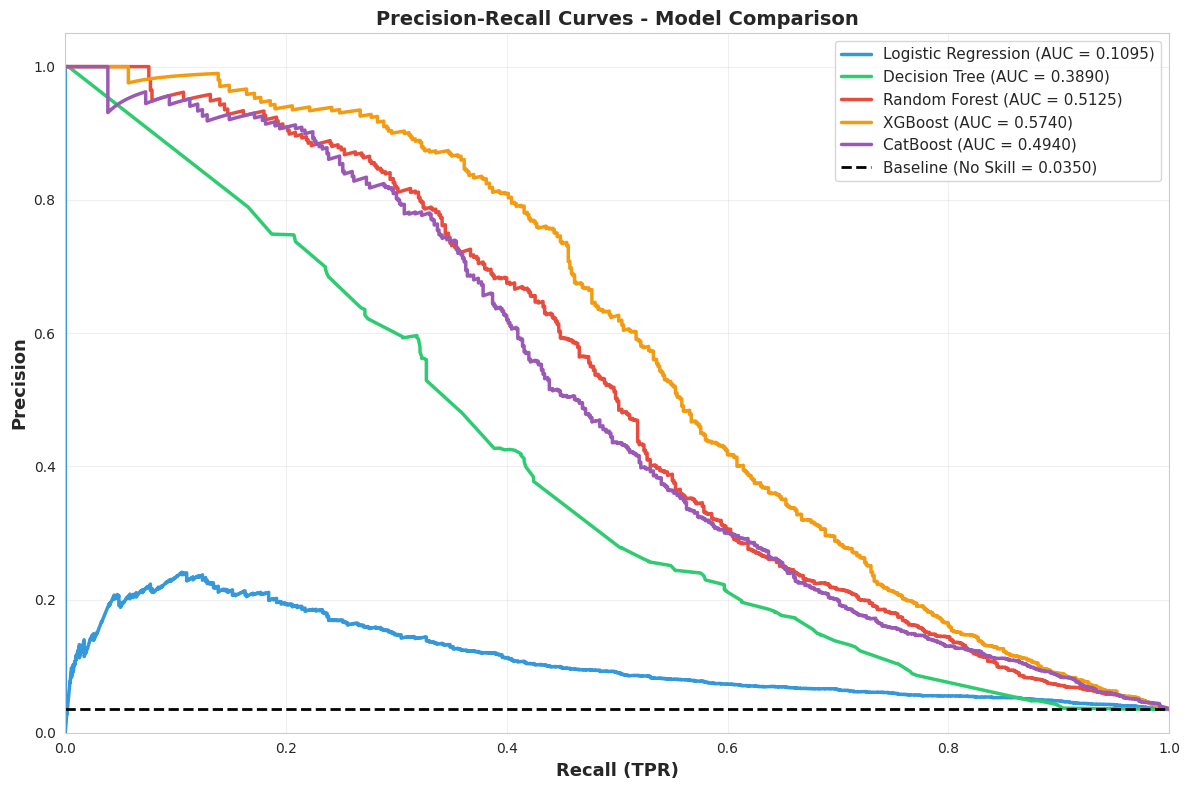


 PRECISION-RECALL INTERPRETATION:
   • Better for IMBALANCED data
   • Top-right corner = Perfect model
   • High Recall: Catches most frauds
   • High Precision: Few false alarms
   • Trade-off: Can't maximize both!


In [ ]:
print("="*70)
print("PRECISION-RECALL CURVES")
print("="*70)

plt.figure(figsize=(12, 8))

for idx, row in detailed_df.iterrows():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, row['y_pred_proba'])
    pr_auc = auc(recall_curve, precision_curve)

    plt.plot(recall_curve, precision_curve, color=colors[idx], linewidth=2.5,
            label=f"{row['Model']} (AUC = {pr_auc:.4f})")

# Baseline (no-skill classifier)
baseline = y_test.sum() / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', linewidth=2,
           label=f'Baseline (No Skill = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (TPR)', fontsize=13, fontweight='bold')
plt.ylabel('Precision', fontsize=13, fontweight='bold')
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n PRECISION-RECALL INTERPRETATION:")
print("   • Better for IMBALANCED data")
print("   • Top-right corner = Perfect model")
print("   • High Recall: Catches most frauds")
print("   • High Precision: Few false alarms")
print("   • Trade-off: Can't maximize both!")

In [ ]:
print("="*70)
print("OVERFITTING & UNDERFITTING ANALYSIS")
print("="*70)


overfitting_analysis = []

models_dict = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'CatBoost': cb_model
}

for name, model in models_dict.items():
    # Training performance
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

    # Test performance
    test_roc_auc = results_final[results_final['Model'] == name]['ROC-AUC'].values[0]
    #if the model performs much better on training than test -It likely memorized training patterns/noise → overfitting
    # If both are low - Model too weak → underfitting
    # Gap shows how much performance did we lose when we moved from training data to unseen test data?
    gap = train_roc_auc - test_roc_auc

    # Diagnosis
    if gap > 0.10:
        status = "OVERFITTING"
    elif test_roc_auc < 0.75:
        status = "UNDERFITTING"
    else:
        status = "GOOD FIT"

    print(f"{name}:")
    print(f"   Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"   Test ROC-AUC:  {test_roc_auc:.4f}")
    print(f"   Gap:           {gap:+.4f}")
    print(f"   Status:        {status}")
    print()

    overfitting_analysis.append({
        'Model': name,
        'Train_ROC_AUC': train_roc_auc,
        'Test_ROC_AUC': test_roc_auc,
        'Gap': gap,
        'Status': status
    })

overfit_df = pd.DataFrame(overfitting_analysis)

print("="*70)
print("\n INTERPRETATION:")
print("   Gap < 0.05:    Excellent ")
print("   Gap 0.05-0.10: Acceptable")
print("   Gap > 0.10:    Overfitting")

OVERFITTING & UNDERFITTING ANALYSIS
Logistic Regression:
   Train ROC-AUC: 0.7422
   Test ROC-AUC:  0.7340
   Gap:           +0.0083
   Status:        UNDERFITTING

Decision Tree:
   Train ROC-AUC: 0.9125
   Test ROC-AUC:  0.8052
   Gap:           +0.1073
   Status:        OVERFITTING

Random Forest:
   Train ROC-AUC: 0.9676
   Test ROC-AUC:  0.8859
   Gap:           +0.0817
   Status:        GOOD FIT

XGBoost:
   Train ROC-AUC: 0.9772
   Test ROC-AUC:  0.9030
   Gap:           +0.0742
   Status:        GOOD FIT

CatBoost:
   Train ROC-AUC: 0.9241
   Test ROC-AUC:  0.8882
   Gap:           +0.0359
   Status:        GOOD FIT


 INTERPRETATION:
   Gap < 0.05:    Excellent 
   Gap 0.05-0.10: Acceptable
   Gap > 0.10:    Overfitting


In [ ]:
print("="*70)
print("FINAL MODEL RECOMMENDATION")
print("="*70)

# Find best model
best_model_idx = results_final['ROC-AUC'].idxmax()
best_model_row = results_final.loc[best_model_idx]
best_model_name = best_model_row['Model']

# Get detailed metrics
best_detailed = detailed_df[detailed_df['Model'] == best_model_name].iloc[0]
best_overfit = overfit_df[overfit_df['Model'] == best_model_name].iloc[0]

print(f"\n🏆 RECOMMENDED MODEL: {best_model_name}")
print("="*70)

print(f" Performance Metrics:")
print(f"   ROC-AUC:    {best_model_row['ROC-AUC']:.4f} ⭐")
print(f"   F1-Score:   {best_model_row['F1-Score']:.4f}")
print(f"   Accuracy:   {best_model_row['Accuracy']:.4f}")
print(f"   Precision:  {best_model_row['Precision']:.4f} ({best_model_row['Precision']*100:.1f}% of alerts real)")
print(f"   Recall:     {best_model_row['Recall']:.4f} (Catches {best_model_row['Recall']*100:.1f}% of frauds)")
print(f"   TPR:        {best_detailed['TPR']:.4f}")
print(f"   TNR:        {best_detailed['TNR']:.4f}")

print(f" Generalization:")
print(f"   Train ROC-AUC: {best_overfit['Train_ROC_AUC']:.4f}")
print(f"   Test ROC-AUC:  {best_overfit['Test_ROC_AUC']:.4f}")
print(f"   Gap:           {best_overfit['Gap']:+.4f}")
print(f"   Status:        {best_overfit['Status']}")

print(f"  Trade-offs:")
print(f"   TP (Frauds caught):        {best_detailed['TP']:.0f} ")
print(f"   TN (Legit identified):     {best_detailed['TN']:.0f} ")
print(f"   FP (False alarms):         {best_detailed['FP']:.0f} ")
print(f"   FN (Missed frauds):        {best_detailed['FN']:.0f} ")

print(f" WHY {best_model_name}?")
if best_model_name in ['XGBoost', 'CatBoost']:
    print(f"   • State-of-the-art gradient boosting")
    print(f"   • Excellent for imbalanced data")
    print(f"   • Industry standard for fraud detection")
    print(f"   • Fast inference for production")
if best_model_name == 'Random Forest':
    print(f"   • Robust ensemble method")
    print(f"   • Resistant to overfitting")
    print(f"   • Easy to interpret")

print(f" BUSINESS IMPACT:")
print(f"   Test set frauds: {y_test.sum():.0f}")
print(f"   Frauds caught: {best_detailed['TP']:.0f} ({best_model_row['Recall']*100:.1f}%)")
print(f"   Frauds missed: {best_detailed['FN']:.0f} ({(1-best_model_row['Recall'])*100:.1f}%)")
print(f"   False alarms: {best_detailed['FP']:.0f} ({best_detailed['FP']/len(y_test)*100:.2f}% of transactions)")


FINAL MODEL RECOMMENDATION

🏆 RECOMMENDED MODEL: XGBoost
 Performance Metrics:
   ROC-AUC:    0.9030 ⭐
   F1-Score:   0.3880
   Accuracy:   0.9206
   Precision:  0.2657 (26.6% of alerts real)
   Recall:     0.7186 (Catches 71.9% of frauds)
   TPR:        0.7186
   TNR:        0.9280
 Generalization:
   Train ROC-AUC: 0.9772
   Test ROC-AUC:  0.9030
   Gap:           +0.0742
   Status:        GOOD FIT
  Trade-offs:
   TP (Frauds caught):        503 
   TN (Legit identified):     17910 
   FP (False alarms):         1390 
   FN (Missed frauds):        197 
 WHY XGBoost?
   • State-of-the-art gradient boosting
   • Excellent for imbalanced data
   • Industry standard for fraud detection
   • Fast inference for production
 BUSINESS IMPACT:
   Test set frauds: 700
   Frauds caught: 503 (71.9%)
   Frauds missed: 197 (28.1%)
   False alarms: 1390 (6.95% of transactions)

    RECOMMENDED FOR DEPLOYMENT
   • Catches majority of frauds
   • Manageable false alarm rate
